Use same as Wilton's IC file for salt restorin

https://github.com/willaguiar/mom6-panAn-iceshelf-tools/blob/main/initial-conditions/WOA_IC_into_8km_grid.ipynb

Updated 21 July 2025 so that salt restoring is correct at E-W boundary

In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
import xesmf as xe
import cftime 
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()#, memory_limit = '1350gb')


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40691,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:40111,Total threads: 2
Dashboard: /proxy/41827/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:36589,


In [4]:
panan01_supergrid = xr.open_mfdataset('/g/data/ik11/inputs/mom6/panan/01deg/20230404/ocean_hgrid.nc')
panan01_IC = xr.open_mfdataset('/g/data/ik11/inputs/mom6/panan/01deg/20230404/forcing/ACCESS-OM2_pottemp_salt_yr2.nc')
salt_restore = xr.open_mfdataset('/g/data/ik11/inputs/mom6/panan/01deg/20230404/salt_restore.nc', decode_cf=False) #what is pauthenet file

In [5]:
salt_restore_25k = xr.open_mfdataset('/g/data/x77/cy8964/mom6/input/input-25km/salt_sfc_restore.nc', decode_cf=False)

In [6]:
salt_restore

<xarray.Dataset> Size: 146MB
Dimensions:  (lat: 845, lon: 3600, time: 12)
Coordinates:
  * lat      (lat) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
  * lon      (lon) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * time     (time) float64 96B 0.5 1.5 2.5 3.5 4.5 ... 7.5 8.5 9.5 10.5 11.5
Data variables:
    salt     (time, lat, lon) float32 146MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
Attributes:
    comment:  This salinity distribution is based on WOA13v2 where the land v...
    history:  Mon Apr 24 13:45:56 2023: ncks -d lat,,844 salt_restore.nc salt...
    NCO:      netCDF Operators version 5.1.3 (Homepage = http://nco.sf.net, C...

In [7]:
#ocean horizontal grid target:
ocean_hgrid_target_dir = '/g/data/x77/ahg157/inputs/mom6/global-8km/ocean_hgrid.nc'
ocean_hgrid_target = xr.open_dataset(ocean_hgrid_target_dir)


In [8]:
#interpoalting temp to the IC grid
lat_yslice = slice(0,2885) #to cur the ygrid in 37 S - talk to Helen and others about the grid cutup (I currently set it in -37.46271512)
#ocean_hgrid_target_SO = ocean_hgrid_target.isel(nyp=slice(0,2885))
ocean_hgrid_target_SO = ocean_hgrid_target.isel(nxp=slice(1, None, 2), nyp=slice(1, 2885, 2))
data_in = salt_restore.copy()


In [9]:
#for copying attributes
mom6_01_for_attributes = salt_restore.copy()

In [10]:
salt_restore

<xarray.Dataset> Size: 146MB
Dimensions:  (lat: 845, lon: 3600, time: 12)
Coordinates:
  * lat      (lat) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
  * lon      (lon) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * time     (time) float64 96B 0.5 1.5 2.5 3.5 4.5 ... 7.5 8.5 9.5 10.5 11.5
Data variables:
    salt     (time, lat, lon) float32 146MB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
Attributes:
    comment:  This salinity distribution is based on WOA13v2 where the land v...
    history:  Mon Apr 24 13:45:56 2023: ncks -d lat,,844 salt_restore.nc salt...
    NCO:      netCDF Operators version 5.1.3 (Homepage = http://nco.sf.net, C...

In [15]:
salt_restore_8k = salt_restore.interp(lat = ocean_hgrid_target_SO.y, lon = ocean_hgrid_target_SO.x, method = 'nearest').bfill('nyp').bfill('nxp').ffill('nxp').drop({'lat','lon'})
salt_restore_8k = salt_restore_8k.rename({'nyp':'lat','nxp':'lon'})

salt_restore_8k['lat'] = ocean_hgrid_target_SO.isel(nxp=0).y.values
salt_restore_8k['lat'].attrs = mom6_01_for_attributes.lat.attrs

salt_restore_8k['lon'] = ocean_hgrid_target_SO.isel(nyp=0).x.values
salt_restore_8k['lon'].attrs = mom6_01_for_attributes.lon.attrs

salt_restore_8k['salt'].attrs = mom6_01_for_attributes.salt.attrs
salt_restore_8k['time'].attrs = salt_restore_25k.time.attrs

salt_restore_8k.attrs['description'] = 'Interpolated from 10th degree version (for MOM6-SIS2 panan) to 8km grid using xr.interp, method = nearest and bfilling southwards. notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/main/initial-conditions/salt-restoring.ipynb. Added bfilling and ffilling E-W on 21 July 2025.'


In [16]:
salt_restore_8k

<xarray.Dataset> Size: 299MB
Dimensions:  (time: 12, lat: 1442, lon: 4320)
Coordinates:
  * time     (time) float64 96B 0.5 1.5 2.5 3.5 4.5 ... 7.5 8.5 9.5 10.5 11.5
  * lat      (lat) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
  * lon      (lon) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
Data variables:
    salt     (time, lat, lon) float32 299MB dask.array<chunksize=(1, 1442, 4320), meta=np.ndarray>
Attributes:
    comment:      This salinity distribution is based on WOA13v2 where the la...
    history:      Mon Apr 24 13:45:56 2023: ncks -d lat,,844 salt_restore.nc ...
    NCO:          netCDF Operators version 5.1.3 (Homepage = http://nco.sf.ne...
    description:  Interpolated from 10th degree version (for MOM6-SIS2 panan)...

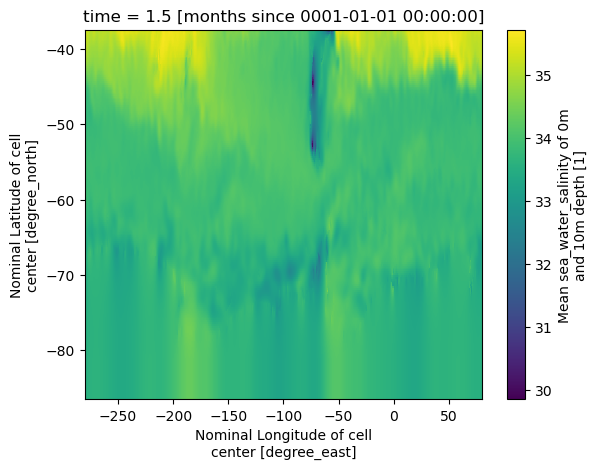

In [17]:
salt_restore_8k.isel(time = 1).salt.plot()

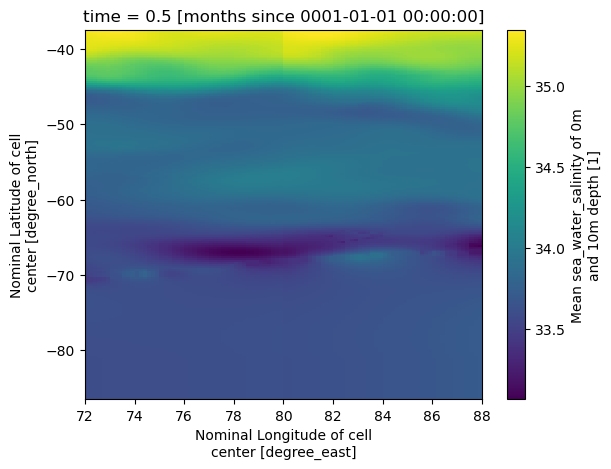

In [18]:
fig,axes = plt.subplots()
ds_shifted = salt_restore_8k.copy()
ds_shifted['lon']=salt_restore_8k.lon.values+360
ds_shifted.salt.isel(time = 0).isel(lon = np.arange(0,100)).plot(add_colorbar = False,ax = axes)
salt_restore_8k.salt.isel(time = 0).isel(lon = np.arange(-100,0)).plot(ax = axes)
plt.xlim(72,88)
plt.show()


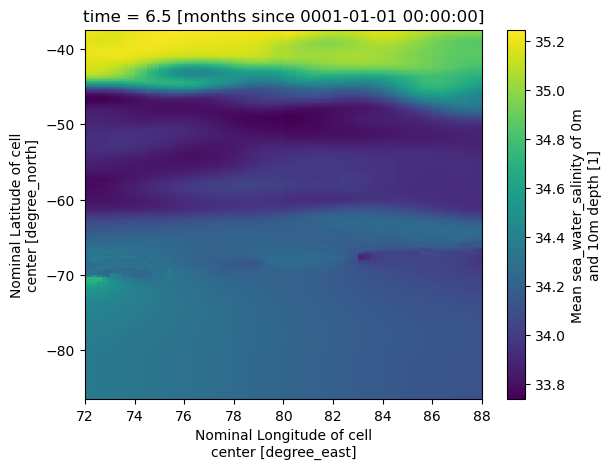

In [19]:
fig,axes = plt.subplots()
ds_shifted = salt_restore_8k.copy()
ds_shifted['lon']=salt_restore_8k.lon.values+360
ds_shifted.salt.isel(time = 6).isel(lon = np.arange(0,100)).plot(add_colorbar = False,ax = axes)
salt_restore_8k.salt.isel(time = 6).isel(lon = np.arange(-100,0)).plot(ax = axes)
plt.xlim(72,88)
plt.show()


In [20]:
enc_TS = {
    "_FillValue": -1.e-20,
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}

In [21]:
salt_restore_8k.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/salt_restore_interpolated_nearest.nc", encoding={ "salt": enc_TS},
                         unlimited_dims={'time':True})

In [22]:
salt_restore_8k.to_netcdf("/g/data/tm70/cy8964/mom6/input/input-8km/salt_restore_interpolated_nearest.nc", encoding={ "salt": enc_TS},
                         unlimited_dims={'time':True})

*Issue:* nearest neighbour interpolation is not ideal.

In [10]:
# did not run.

# import xesmf as xe

# # target grid (t points)
# dg = xr.open_dataset("/g/data/x77/ahg157/inputs/mom6/global-8km/ocean_hgrid.nc").isel(nyp=slice(0,2885))
# dg = (
#     dg[["x", "y"]]
#     .isel(nxp=slice(1, None, 2), nyp=slice(1, None, 2))
#     .rename(x="lon", y="lat")
# )
# regridder = xe.Regridder(
#     data_in.isel(time = 0),#.rename(GRID_X_T="lon", GRID_Y_T="lat"),
#     dg,
#     "bilinear",
#     periodic=True,
#     reuse_weights=False,
#     #filename="bilinear_init_weights.nc",
# )